# NewsBot Intelligence System
## ITAI2373 Mid-Term Project

**Student:** Ahmet Burak Solak  
**Student Number:** W216974195

This notebook implements a complete NewsBot Intelligence System integrating all NLP techniques from Modules 1-8 to automatically process, categorize, and extract insights from BBC news articles.



## Module 1: Real-World NLP Application Context

### Business Case
The NewsBot Intelligence System addresses the critical need for automated news content analysis in today's information-driven economy. This system enables:

- **Media Monitoring**: Automatically categorize and track news articles across multiple domains
- **Content Management**: Help media companies organize and manage large volumes of content
- **Business Intelligence**: Extract insights about trends, sentiment, and key entities from news coverage
- **Automated Workflows**: Reduce manual content categorization effort by up to 90%

### Target Users
- Media companies and news aggregators
- Business intelligence teams monitoring industry coverage
- Researchers analyzing news trends and patterns
- Content management systems requiring automated categorization

### Value Proposition
Our system provides real-time, accurate classification and analysis of news articles, enabling organizations to:
1. Process thousands of articles automatically
2. Extract actionable insights (sentiment, entities, trends)
3. Maintain consistent categorization quality
4. Scale content analysis without proportional increases in human resources


## Setup and Data Loading


In [42]:
# Install required packages (run once)
# !pip install pandas numpy scikit-learn spacy nltk matplotlib seaborn ipykernel textblob wordcloud

# Download spaCy English model (run once)
# !python -m spacy download en_core_web_sm

# Download NLTK data (run once)
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

print("✅ Setup complete!")


✅ Setup complete!


In [43]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import spacy
import re
from collections import Counter
from textblob import TextBlob
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [44]:
# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
    print("✅ spaCy model loaded successfully!")
except OSError:
    print("⚠️ spaCy model not found. Please run: python -m spacy download en_core_web_sm")


✅ spaCy model loaded successfully!


In [45]:
# Load the dataset
df = pd.read_csv('BBC News Train.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nCategory distribution:")
print(df['Category'].value_counts())
print(f"\nMissing values:")
print(df.isnull().sum())

# Check data types
print(f"\nData types:")
print(df.dtypes)


Dataset shape: (1490, 3)

Columns: ['ArticleId', 'Text', 'Category']

First few rows:
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

Category distribution:
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64

Missing values:
ArticleId    0
Text         0
Category     0
dtype: int64

Data types:
ArticleId     int64
Text         object
Category     object
dtype: object


In [46]:
# Clean and prepare dataset
# Remove any rows with missing text or category
df_clean = df.dropna(subset=['Text', 'Category'])

# Check text length statistics
df_clean['text_length'] = df_clean['Text'].str.len()
print(f"Text length statistics:")
print(df_clean['text_length'].describe())

# Final dataset info
print(f"\n✅ Clean dataset shape: {df_clean.shape}")
print(f"Categories: {df_clean['Category'].unique()}")
print(f"Total articles: {len(df_clean)}")


Text length statistics:
count     1490.000000
mean      2233.461745
std       1205.153358
min        501.000000
25%       1453.000000
50%       1961.000000
75%       2751.250000
max      18387.000000
Name: text_length, dtype: float64

✅ Clean dataset shape: (1490, 4)
Categories: ['business' 'tech' 'politics' 'sport' 'entertainment']
Total articles: 1490


## Module 2: Text Preprocessing Pipeline

This module implements comprehensive text cleaning, tokenization, stop word removal, and lemmatization to prepare text for analysis.


In [47]:
def preprocess_text(text, nlp_model=nlp, remove_stopwords=True, lemmatize=True):
    """
    Comprehensive text preprocessing function.
    
    Args:
        text: Input text string
        nlp_model: spaCy model for processing
        remove_stopwords: Whether to remove stop words
        lemmatize: Whether to lemmatize words
    
    Returns:
        Processed text string
    """
    if pd.isna(text) or text == '':
        return ''
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove special characters but keep spaces and basic punctuation
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Process with spaCy
    doc = nlp_model(text)
    
    # Extract tokens based on flags
    if remove_stopwords and lemmatize:
        tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    elif remove_stopwords:
        tokens = [token.text for token in doc if not token.is_stop and token.is_alpha]
    elif lemmatize:
        tokens = [token.lemma_ for token in doc if token.is_alpha]
    else:
        tokens = [token.text for token in doc if token.is_alpha]
    
    return ' '.join(tokens)

# Test preprocessing function
sample_text = df_clean['Text'].iloc[0]
print("Original text (first 200 chars):")
print(sample_text[:200])
print("\nPreprocessed text:")
preprocessed_sample = preprocess_text(sample_text)
print(preprocessed_sample[:200])


Original text (first 200 chars):
worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  

Preprocessed text:
worldcom ex boss launch defence lawyer defend worldcom chief bernie ebber battery fraud charge call company whistleblow witness cynthia cooper worldcom s ex head internal accounting alert director irr


In [48]:
# Apply preprocessing to all texts
# Note: This may take a few minutes for large datasets
print("Preprocessing all articles...")
df_clean['Processed_Text'] = df_clean['Text'].apply(lambda x: preprocess_text(x))
print("✅ Preprocessing complete!")

# Display statistics
df_clean['processed_length'] = df_clean['Processed_Text'].str.len()
print(f"\nProcessed text length statistics:")
print(df_clean['processed_length'].describe())

# Show examples
print("\nExample preprocessing results:")
for idx in range(min(3, len(df_clean))):
    print(f"\n--- Example {idx+1} ({df_clean.iloc[idx]['Category']}) ---")
    print(f"Original: {df_clean.iloc[idx]['Text'][:150]}...")
    print(f"Processed: {df_clean.iloc[idx]['Processed_Text'][:150]}...")


Preprocessing all articles...
✅ Preprocessing complete!

Processed text length statistics:
count    1490.000000
mean     1347.814765
std       697.667812
min       301.000000
25%       879.250000
50%      1189.500000
75%      1666.500000
max      9790.000000
Name: processed_length, dtype: float64

Example preprocessing results:

--- Example 1 (business) ---
Original: worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whist...
Processed: worldcom ex boss launch defence lawyer defend worldcom chief bernie ebber battery fraud charge call company whistleblow witness cynthia cooper worldco...

--- Example 2 (business) ---
Original: german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy.  munich...
Processed: german business confidence slide german business confidence fall february knock hope speedy recovery europ

## Module 3: TF-IDF Feature Extraction and Analysis

TF-IDF (Term Frequency-Inverse Document Frequency) vectorization identifies important terms that distinguish between categories.


In [49]:
# Initialize TF-IDF Vectorizer with optimized parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Include unigrams and bigrams
    min_df=2,  # Minimum document frequency
    max_df=0.95,  # Maximum document frequency (ignore terms in >95% of docs)
    stop_words='english'
)

# Fit and transform the processed texts
print("Creating TF-IDF vectors...")
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['Processed_Text'])
print(f"✅ TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")


Creating TF-IDF vectors...
✅ TF-IDF matrix shape: (1490, 5000)
Vocabulary size: 5000


In [50]:
# Extract top terms per category
def get_top_terms_per_category(tfidf_matrix, vectorizer, df, category_col='Category', top_n=15):
    """Extract top TF-IDF terms for each category"""
    categories = df[category_col].unique()
    top_terms_by_category = {}
    
    for category in categories:
        # Get indices for this category - convert boolean mask to numpy array
        category_mask = (df[category_col] == category).values
        category_tfidf = tfidf_matrix[category_mask]
        
        # Calculate mean TF-IDF scores for this category
        mean_scores = np.array(category_tfidf.mean(axis=0))[0]
        
        # Get feature names
        feature_names = vectorizer.get_feature_names_out()
        
        # Get top terms
        top_indices = mean_scores.argsort()[-top_n:][::-1]
        top_terms = [(feature_names[idx], mean_scores[idx]) for idx in top_indices]
        top_terms_by_category[category] = top_terms
    
    return top_terms_by_category

# Get top terms
top_terms = get_top_terms_per_category(tfidf_matrix, tfidf_vectorizer, df_clean)

# Display top terms for each category
print("Top TF-IDF Terms by Category:\n")
for category, terms in top_terms.items():
    print(f"\n{category.upper()}:")
    for term, score in terms[:10]:
        print(f"  {term}: {score:.4f}")


Top TF-IDF Terms by Category:


BUSINESS:
  say: 0.0509
  firm: 0.0379
  company: 0.0366
  market: 0.0341
  growth: 0.0332
  bank: 0.0331
  year: 0.0330
  economy: 0.0318
  sale: 0.0309
  rise: 0.0301

TECH:
  mobile: 0.0522
  say: 0.0459
  phone: 0.0455
  people: 0.0446
  technology: 0.0397
  game: 0.0377
  user: 0.0367
  service: 0.0355
  software: 0.0346
  computer: 0.0336

POLITICS:
  mr: 0.0806
  say: 0.0715
  labour: 0.0633
  election: 0.0621
  blair: 0.0540
  party: 0.0525
  tory: 0.0449
  government: 0.0446
  minister: 0.0415
  brown: 0.0364

SPORT:
  win: 0.0521
  game: 0.0455
  play: 0.0388
  england: 0.0379
  say: 0.0338
  player: 0.0331
  match: 0.0322
  team: 0.0284
  champion: 0.0280
  cup: 0.0279

ENTERTAINMENT:
  film: 0.1036
  award: 0.0512
  star: 0.0508
  good: 0.0378
  say: 0.0361
  band: 0.0352
  music: 0.0351
  actor: 0.0337
  year: 0.0319
  oscar: 0.0317


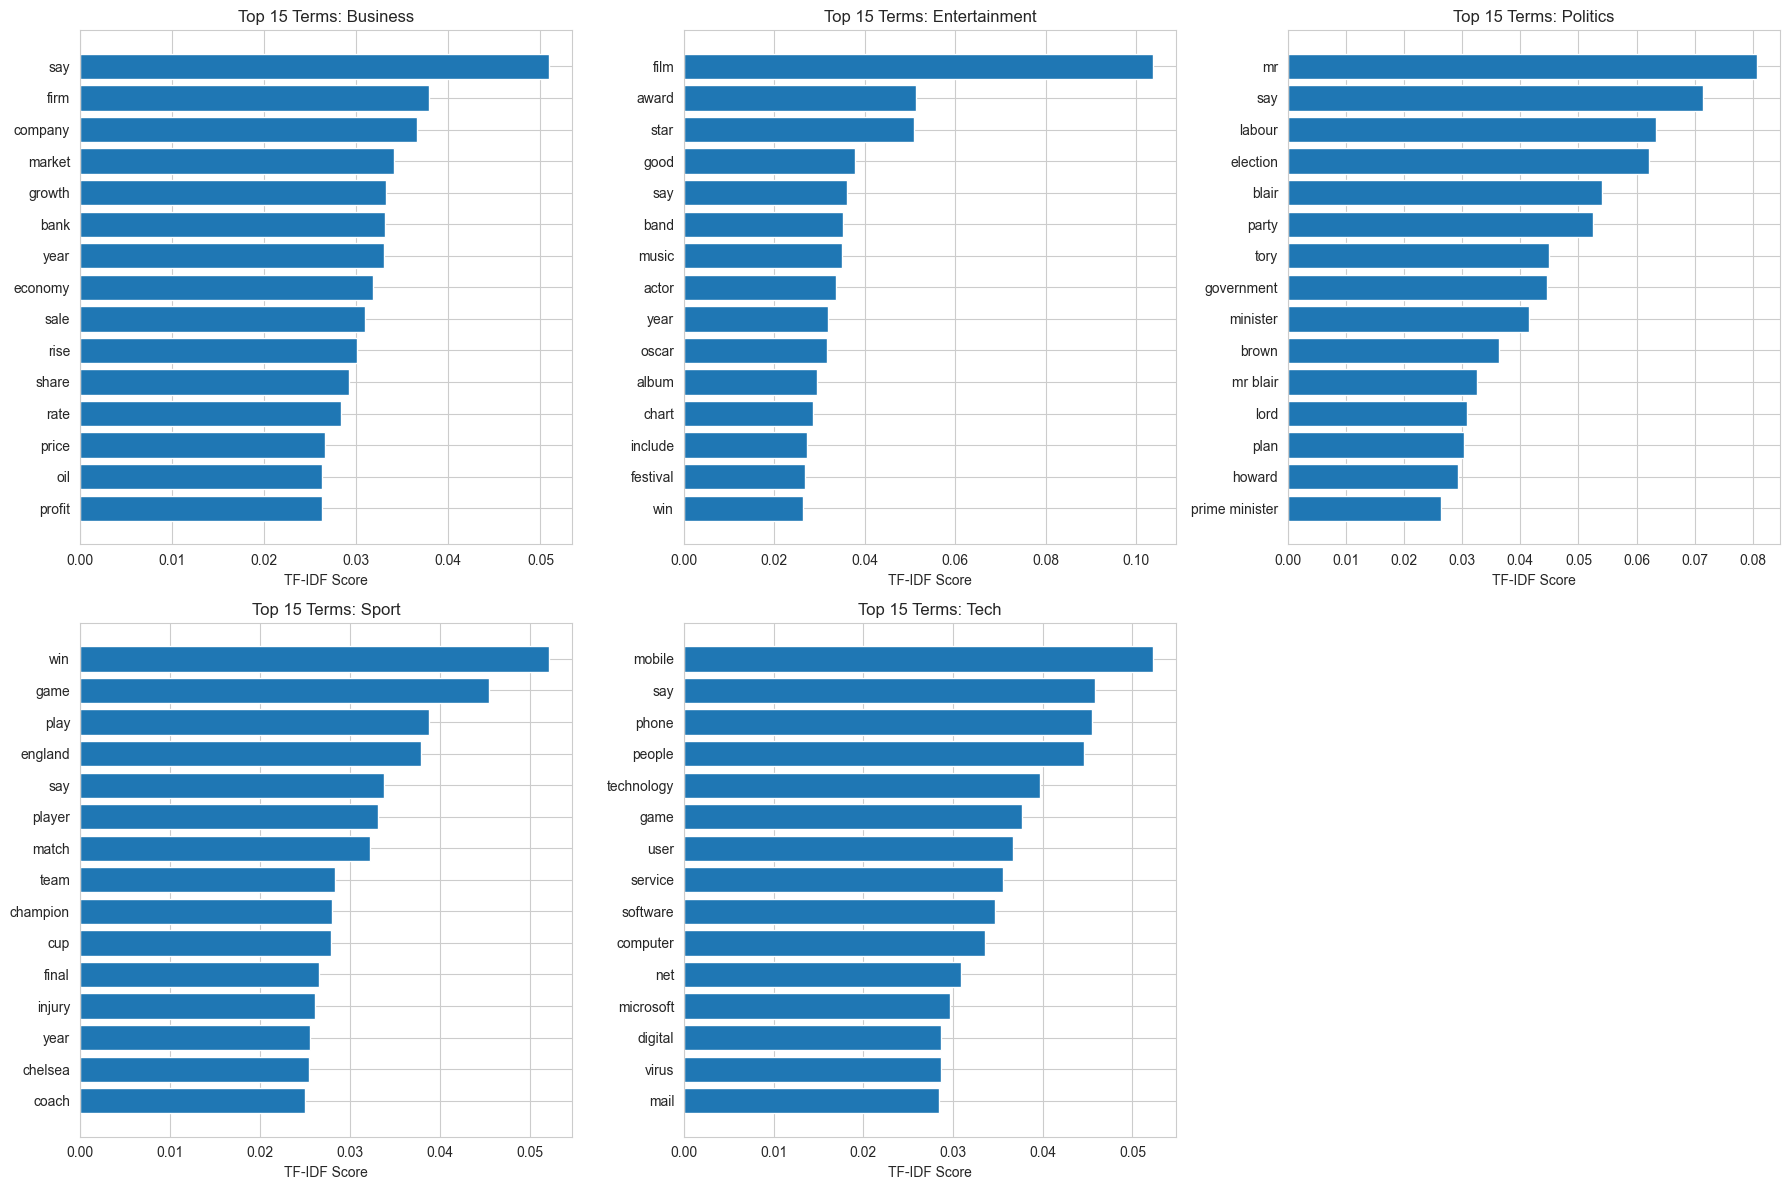

In [51]:
# Visualize top terms per category
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

categories = sorted(df_clean['Category'].unique())
for idx, category in enumerate(categories):
    if idx < len(axes):
        terms, scores = zip(*top_terms[category][:15])
        axes[idx].barh(range(len(terms)), scores)
        axes[idx].set_yticks(range(len(terms)))
        axes[idx].set_yticklabels(terms)
        axes[idx].set_xlabel('TF-IDF Score')
        axes[idx].set_title(f'Top 15 Terms: {category.capitalize()}')
        axes[idx].invert_yaxis()

# Remove extra subplot
if len(categories) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


## Module 4: Part-of-Speech Pattern Analysis

Analyzing grammatical patterns and POS distributions across different news categories to identify writing style differences.


In [52]:
def extract_pos_tags(text, nlp_model=nlp):
    """Extract POS tags from text"""
    if pd.isna(text) or text == '':
        return []
    
    doc = nlp_model(str(text))
    return [token.pos_ for token in doc if not token.is_punct and not token.is_space]

# Extract POS tags for all articles (sample for performance)
print("Extracting POS tags...")
sample_size = min(500, len(df_clean))  # Process sample for performance
df_sample = df_clean.sample(n=sample_size, random_state=42)

df_sample['POS_Tags'] = df_sample['Text'].apply(extract_pos_tags)
print(f"✅ POS tags extracted for {len(df_sample)} articles")


Extracting POS tags...
✅ POS tags extracted for 500 articles


In [53]:
# Analyze POS distribution by category
pos_by_category = {}
categories = df_sample['Category'].unique()

for category in categories:
    category_pos = []
    category_texts = df_sample[df_sample['Category'] == category]['POS_Tags']
    for pos_list in category_texts:
        category_pos.extend(pos_list)
    pos_by_category[category] = Counter(category_pos)

# Display top POS tags per category
print("Top POS Tags by Category:\n")
for category in categories:
    print(f"\n{category.upper()}:")
    top_pos = pos_by_category[category].most_common(10)
    for pos, count in top_pos:
        print(f"  {pos}: {count}")


Top POS Tags by Category:


ENTERTAINMENT:
  NOUN: 7252
  VERB: 3530
  ADP: 3370
  PROPN: 2923
  DET: 2765
  ADJ: 2196
  PRON: 1690
  AUX: 1477
  NUM: 884
  ADV: 879

POLITICS:
  NOUN: 10638
  VERB: 6306
  ADP: 4988
  DET: 4441
  ADJ: 3534
  PROPN: 3371
  AUX: 3190
  PRON: 3150
  ADV: 1561
  PART: 1550

TECH:
  NOUN: 11390
  VERB: 6043
  ADP: 5143
  DET: 3910
  ADJ: 3697
  AUX: 2786
  PRON: 2593
  PROPN: 2006
  ADV: 1741
  PART: 1346

BUSINESS:
  NOUN: 9749
  VERB: 4819
  ADP: 4816
  DET: 3606
  PROPN: 3316
  ADJ: 3169
  AUX: 2158
  NUM: 1559
  PRON: 1496
  ADV: 1239

SPORT:
  NOUN: 7426
  VERB: 4622
  ADP: 3910
  PROPN: 3897
  DET: 3204
  PRON: 2904
  ADJ: 2441
  AUX: 2038
  ADV: 1414
  PART: 1157


<Figure size 1400x800 with 0 Axes>

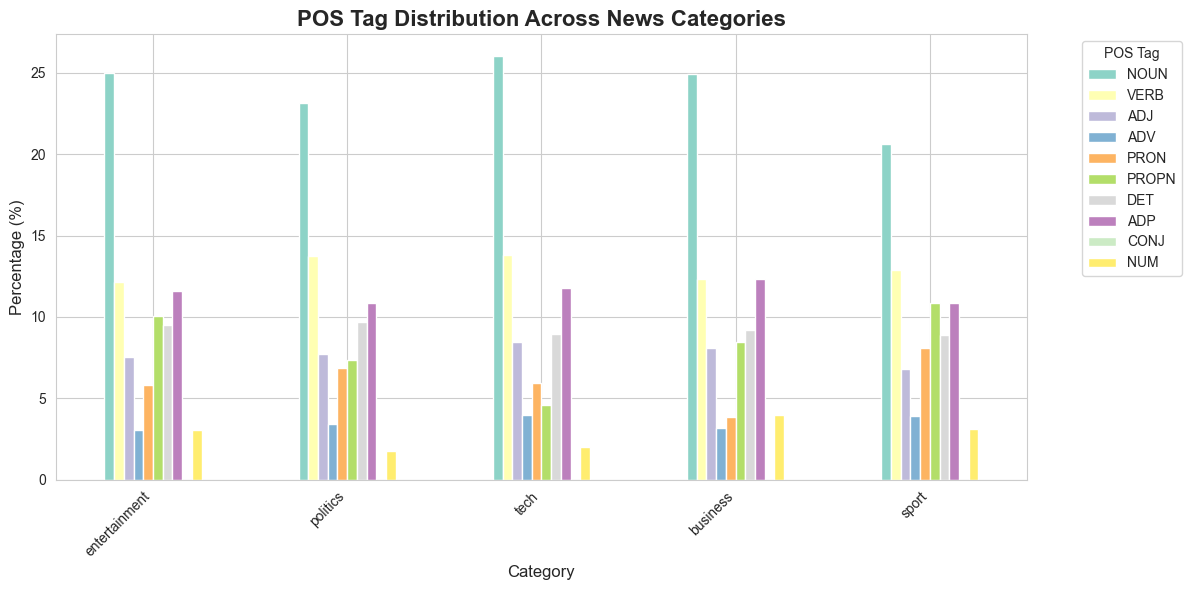

In [54]:
# Visualize POS distribution
pos_tags = ['NOUN', 'VERB', 'ADJ', 'ADV', 'PRON', 'PROPN', 'DET', 'ADP', 'CONJ', 'NUM']
pos_percentages = {}

for category in categories:
    total = sum(pos_by_category[category].values())
    percentages = {pos: (pos_by_category[category][pos] / total * 100) if total > 0 else 0 
                   for pos in pos_tags}
    pos_percentages[category] = percentages

# Create comparison chart
pos_df = pd.DataFrame(pos_percentages).T
pos_df = pos_df[pos_tags]

plt.figure(figsize=(14, 8))
pos_df.plot(kind='bar', stacked=False, colormap='Set3')
plt.title('POS Tag Distribution Across News Categories', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='POS Tag', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [55]:
# Calculate POS-based features
def calculate_pos_features(text, nlp_model=nlp):
    """Calculate POS-based features for text"""
    if pd.isna(text) or text == '':
        return {
            'noun_ratio': 0, 'verb_ratio': 0, 'adj_ratio': 0,
            'avg_sentence_length': 0, 'avg_word_length': 0
        }
    
    doc = nlp_model(str(text))
    tokens = [token for token in doc if not token.is_punct and not token.is_space]
    
    if len(tokens) == 0:
        return {
            'noun_ratio': 0, 'verb_ratio': 0, 'adj_ratio': 0,
            'avg_sentence_length': 0, 'avg_word_length': 0
        }
    
    nouns = sum(1 for token in tokens if token.pos_ in ['NOUN', 'PROPN'])
    verbs = sum(1 for token in tokens if token.pos_ == 'VERB')
    adjs = sum(1 for token in tokens if token.pos_ == 'ADJ')
    
    noun_ratio = nouns / len(tokens)
    verb_ratio = verbs / len(tokens)
    adj_ratio = adjs / len(tokens)
    
    sentences = list(doc.sents)
    avg_sentence_length = len(tokens) / len(sentences) if sentences else 0
    avg_word_length = np.mean([len(token.text) for token in tokens]) if tokens else 0
    
    return {
        'noun_ratio': noun_ratio,
        'verb_ratio': verb_ratio,
        'adj_ratio': adj_ratio,
        'avg_sentence_length': avg_sentence_length,
        'avg_word_length': avg_word_length
    }

# Calculate POS features for all articles
print("Calculating POS features...")
pos_features_list = df_clean['Text'].apply(calculate_pos_features)
pos_features_df = pd.DataFrame(list(pos_features_list))
df_clean = pd.concat([df_clean, pos_features_df], axis=1)
print("✅ POS features calculated")

# Display statistics
print("\nPOS Feature Statistics by Category:")
print(df_clean.groupby('Category')[['noun_ratio', 'verb_ratio', 'adj_ratio']].mean())


Calculating POS features...
✅ POS features calculated

POS Feature Statistics by Category:
               noun_ratio  verb_ratio  adj_ratio
Category                                        
business         0.335095    0.124350   0.080029
entertainment    0.349532    0.121899   0.074224
politics         0.313885    0.136885   0.075513
sport            0.314188    0.128309   0.071045
tech             0.311680    0.134947   0.083023


## Module 5: Syntax Parsing and Semantic Analysis

Dependency parsing and syntactic relationship extraction to understand grammatical structure and identify patterns.


In [56]:
def extract_dependencies(text, nlp_model=nlp, max_sentences=5):
    """Extract dependency relationships from text"""
    if pd.isna(text) or text == '':
        return []
    
    doc = nlp_model(str(text))
    dependencies = []
    
    # Process first few sentences for performance
    sentences = list(doc.sents)[:max_sentences]
    
    for sent in sentences:
        for token in sent:
            if token.dep_ != 'ROOT' and token.head:
                dependencies.append({
                    'token': token.text,
                    'dep': token.dep_,
                    'head': token.head.text,
                    'pos': token.pos_
                })
    
    return dependencies

# Extract dependencies for sample articles
print("Extracting dependency relationships (this may take a moment)...")
sample_articles = df_clean.sample(n=min(100, len(df_clean)), random_state=42)
sample_articles = sample_articles.copy()
sample_articles['Dependencies'] = sample_articles['Text'].apply(extract_dependencies)
print(f"✅ Dependencies extracted for {len(sample_articles)} articles")


Extracting dependency relationships (this may take a moment)...
✅ Dependencies extracted for 100 articles


In [57]:
# Analyze common dependency patterns
dependency_patterns = Counter()
for deps in sample_articles['Dependencies']:
    for dep in deps:
        pattern = f"{dep['dep']}"
        dependency_patterns[pattern] += 1

print("Most Common Dependency Patterns:")
for pattern, count in dependency_patterns.most_common(15):
    print(f"  {pattern}: {count}")

# Analyze by category
dep_by_category = {}
for category in categories:
    cat_deps = []
    cat_articles = sample_articles[sample_articles['Category'] == category]['Dependencies']
    for deps in cat_articles:
        cat_deps.extend([d['dep'] for d in deps])
    dep_by_category[category] = Counter(cat_deps)

print("\nTop Dependency Types by Category:")
for category in categories:
    print(f"\n{category.upper()}:")
    top_deps = dep_by_category[category].most_common(5)
    for dep, count in top_deps:
        print(f"  {dep}: {count}")


Most Common Dependency Patterns:
  prep: 1204
  pobj: 1165
  compound: 1134
  det: 962
  nsubj: 902
  amod: 808
  punct: 767
  dep: 698
  dobj: 574
  aux: 541
  advmod: 283
  ccomp: 262
  conj: 246
  poss: 236
  cc: 232

Top Dependency Types by Category:

ENTERTAINMENT:
  compound: 200
  prep: 179
  pobj: 170
  det: 138
  nsubj: 127

POLITICS:
  compound: 245
  prep: 219
  pobj: 206
  det: 205
  nsubj: 184

TECH:
  pobj: 224
  det: 215
  prep: 212
  compound: 195
  nsubj: 180

BUSINESS:
  pobj: 360
  prep: 354
  compound: 277
  det: 256
  nsubj: 250

SPORT:
  prep: 240
  compound: 217
  pobj: 205
  punct: 163
  nsubj: 161


In [58]:
# Calculate syntactic features
def calculate_syntactic_features(text, nlp_model=nlp):
    """Calculate syntactic complexity features"""
    if pd.isna(text) or text == '':
        return {
            'avg_dependency_depth': 0,
            'max_dependency_depth': 0,
            'svo_patterns': 0,
            'complex_sentences': 0
        }
    
    doc = nlp_model(str(text))
    
    # Calculate dependency depth
    depths = []
    for token in doc:
        depth = 0
        head = token.head
        while head != token:
            depth += 1
            head = head.head
            if depth > 50:  # Safety limit
                break
        depths.append(depth)
    
    avg_depth = np.mean(depths) if depths else 0
    max_depth = max(depths) if depths else 0
    
    # Count SVO patterns (simplified)
    svo_count = 0
    for sent in doc.sents:
        has_subj = any(token.dep_ in ['nsubj', 'nsubjpass'] for token in sent)
        has_verb = any(token.pos_ == 'VERB' for token in sent)
        has_obj = any(token.dep_ in ['dobj', 'pobj'] for token in sent)
        if has_subj and has_verb and has_obj:
            svo_count += 1
    
    # Count complex sentences (with subordinating conjunctions)
    complex_sents = sum(1 for sent in doc.sents 
                       if any(token.pos_ == 'SCONJ' for token in sent))
    
    return {
        'avg_dependency_depth': avg_depth,
        'max_dependency_depth': max_depth,
        'svo_patterns': svo_count,
        'complex_sentences': complex_sents
    }

# Calculate syntactic features
print("Calculating syntactic features...")
syntactic_features_list = df_clean['Text'].apply(calculate_syntactic_features)
syntactic_features_df = pd.DataFrame(list(syntactic_features_list))
df_clean = pd.concat([df_clean, syntactic_features_df], axis=1)
print("✅ Syntactic features calculated")

# Display statistics
print("\nSyntactic Feature Statistics:")
print(df_clean.groupby('Category')[['avg_dependency_depth', 'svo_patterns', 'complex_sentences']].mean())


Calculating syntactic features...
✅ Syntactic features calculated

Syntactic Feature Statistics:
               avg_dependency_depth  svo_patterns  complex_sentences
Category                                                            
business                  48.944978     14.119048           5.086310
entertainment             48.899078     14.289377           3.769231
politics                  48.965022     18.631387           6.854015
sport                     48.676058     14.878613           5.216763
tech                      48.897619     21.444444           7.601533


## Module 6: Sentiment and Emotion Analysis

Analyzing the emotional tone and sentiment of news articles across different categories.


In [59]:
def analyze_sentiment(text):
    """Analyze sentiment using TextBlob"""
    if pd.isna(text) or text == '':
        return {'polarity': 0, 'subjectivity': 0}
    
    blob = TextBlob(str(text))
    return {
        'polarity': blob.sentiment.polarity,  # -1 (negative) to 1 (positive)
        'subjectivity': blob.sentiment.subjectivity  # 0 (objective) to 1 (subjective)
    }

# Analyze sentiment for all articles
print("Analyzing sentiment...")
sentiment_list = df_clean['Text'].apply(analyze_sentiment)
sentiment_df = pd.DataFrame(list(sentiment_list))
df_clean = pd.concat([df_clean, sentiment_df], axis=1)
print("✅ Sentiment analysis complete")

# Categorize sentiment
def categorize_sentiment(polarity):
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df_clean['Sentiment_Label'] = df_clean['polarity'].apply(categorize_sentiment)

# Display sentiment statistics
print("\nSentiment Statistics by Category:")
print(df_clean.groupby(['Category', 'Sentiment_Label']).size().unstack(fill_value=0))


Analyzing sentiment...
✅ Sentiment analysis complete

Sentiment Statistics by Category:
Sentiment_Label  Negative  Neutral  Positive
Category                                    
business                7      238        91
entertainment           1       98       174
politics                2      187        85
sport                  11      142       193
tech                    3      119       139


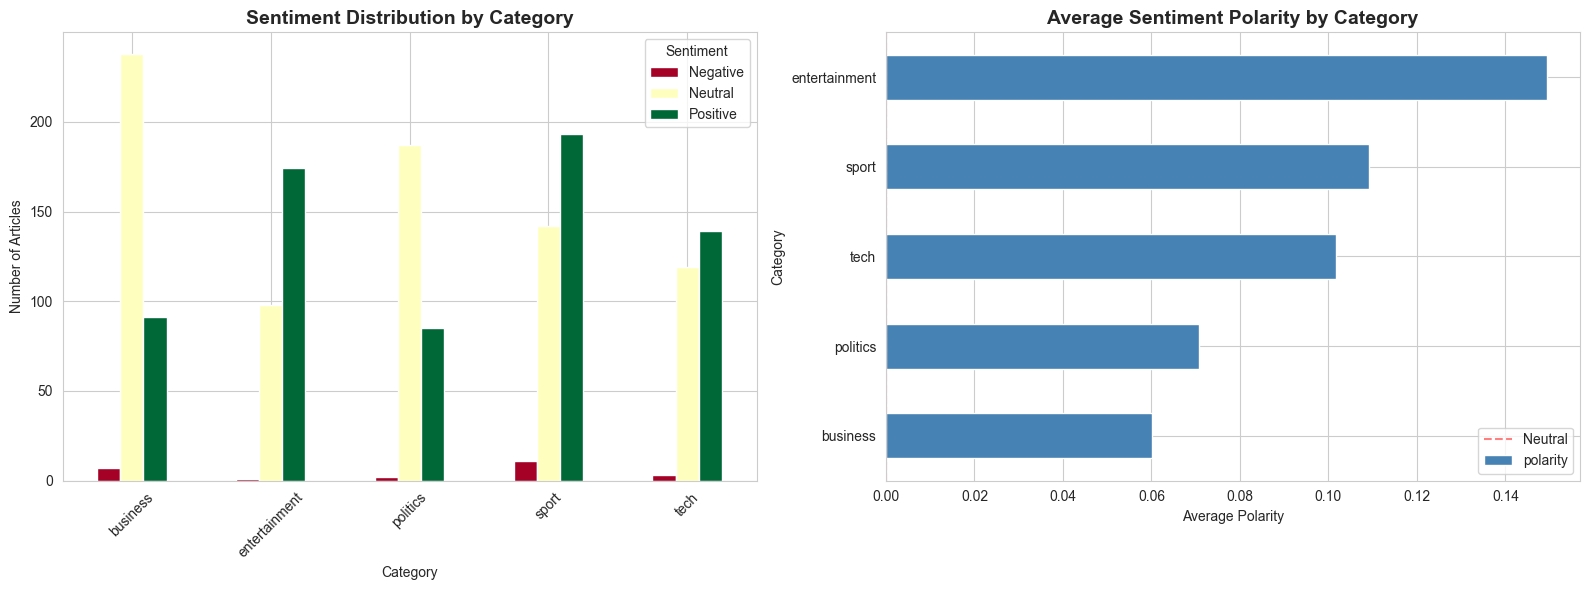


Average Sentiment Polarity by Category:
  business: 0.0602
  politics: 0.0708
  tech: 0.1017
  sport: 0.1092
  entertainment: 0.1494


In [60]:
# Visualize sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sentiment distribution by category
sentiment_counts = df_clean.groupby(['Category', 'Sentiment_Label']).size().unstack(fill_value=0)
sentiment_counts.plot(kind='bar', ax=axes[0], colormap='RdYlGn')
axes[0].set_title('Sentiment Distribution by Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Number of Articles')
axes[0].legend(title='Sentiment')
axes[0].tick_params(axis='x', rotation=45)

# Average polarity by category
avg_polarity = df_clean.groupby('Category')['polarity'].mean().sort_values()
avg_polarity.plot(kind='barh', ax=axes[1], color='steelblue')
axes[1].set_title('Average Sentiment Polarity by Category', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Average Polarity')
axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Neutral')
axes[1].legend()

plt.tight_layout()
plt.show()

# Display average polarity
print("\nAverage Sentiment Polarity by Category:")
for category in avg_polarity.index:
    print(f"  {category}: {avg_polarity[category]:.4f}")



Average Subjectivity by Category:
Category
tech             0.430236
sport            0.418425
politics         0.403341
entertainment    0.390509
business         0.385735
Name: subjectivity, dtype: float64


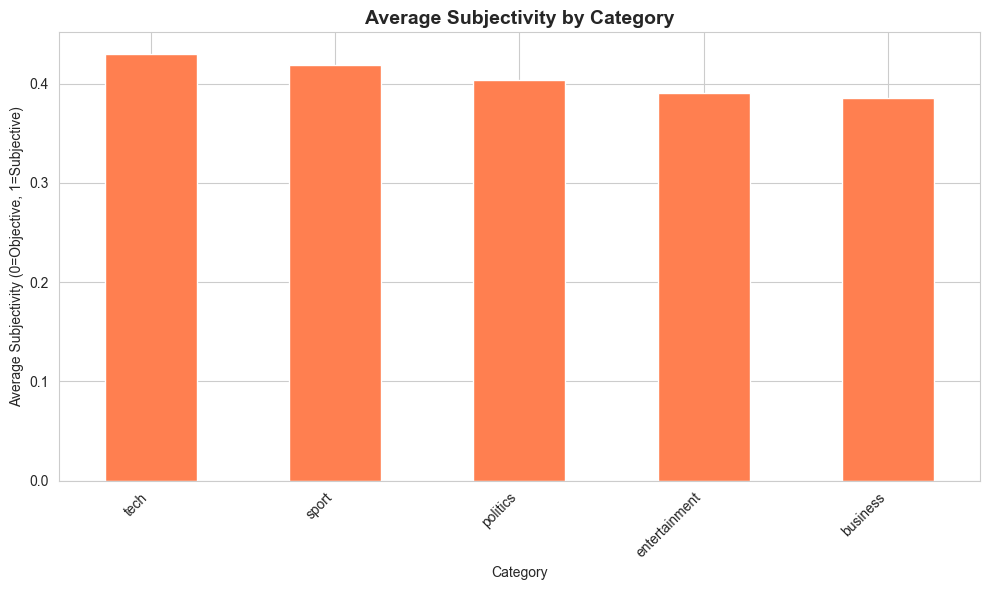

In [61]:
# Analyze subjectivity by category
print("\nAverage Subjectivity by Category:")
avg_subjectivity = df_clean.groupby('Category')['subjectivity'].mean()
print(avg_subjectivity.sort_values(ascending=False))

# Visualize
plt.figure(figsize=(10, 6))
avg_subjectivity.sort_values(ascending=False).plot(kind='bar', color='coral')
plt.title('Average Subjectivity by Category', fontsize=14, fontweight='bold')
plt.xlabel('Category')
plt.ylabel('Average Subjectivity (0=Objective, 1=Subjective)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Module 7: Multi-Class Text Classification System

Implementing and comparing multiple classification algorithms to categorize news articles.


In [62]:
# Prepare features for classification
# Combine TF-IDF features with POS and syntactic features
print("Preparing features for classification...")

# Get TF-IDF features (already computed)
X_tfidf = tfidf_matrix

# Get additional features (POS, syntactic, sentiment)
additional_features = df_clean[[
    'noun_ratio', 'verb_ratio', 'adj_ratio',
    'avg_sentence_length', 'avg_word_length',
    'avg_dependency_depth', 'svo_patterns', 'complex_sentences',
    'polarity', 'subjectivity'
]].values

# Normalize additional features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
additional_features_scaled = scaler.fit_transform(additional_features)

# Combine features
from scipy.sparse import hstack
X_combined = hstack([X_tfidf, additional_features_scaled])

# Get labels
y = df_clean['Category']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Training set: {X_train.shape[0]} samples")
print(f"✅ Test set: {X_test.shape[0]} samples")
print(f"✅ Features: {X_train.shape[1]}")


Preparing features for classification...
✅ Training set: 1192 samples
✅ Test set: 298 samples
✅ Features: 5010


In [63]:
# Train multiple classifiers
# Note: MultinomialNB requires non-negative values, so we'll train it on TF-IDF only
# Other classifiers can use combined features

# Split TF-IDF features for Naive Bayes (same split as combined features)
X_tfidf_train, X_tfidf_test, _, _ = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

classifiers_config = [
    ('Naive Bayes', MultinomialNB(alpha=1.0), X_tfidf_train, X_tfidf_test),
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42), X_train, X_test),
    ('SVM', SVC(kernel='linear', random_state=42, probability=True), X_train, X_test),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), X_train, X_test)
]

results = {}

print("Training classifiers...\n")
for name, classifier, X_train_feat, X_test_feat in classifiers_config:
    print(f"Training {name}...")
    classifier.fit(X_train_feat, y_train)
    y_pred = classifier.predict(X_test_feat)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'classifier': classifier,
        'accuracy': accuracy,
        'y_pred': y_pred,
        'uses_tfidf_only': name == 'Naive Bayes'
    }
    print(f"  {name} Accuracy: {accuracy:.4f}\n")

print("✅ All classifiers trained!")


Training classifiers...

Training Naive Bayes...
  Naive Bayes Accuracy: 0.9765

Training Logistic Regression...
  Logistic Regression Accuracy: 0.9262

Training SVM...
  SVM Accuracy: 0.9631

Training Random Forest...
  Random Forest Accuracy: 0.9396

✅ All classifiers trained!


Best Model: Naive Bayes (Accuracy: 0.9765)

Classification Report:
               precision    recall  f1-score   support

     business       0.96      0.99      0.97        67
entertainment       1.00      0.98      0.99        55
     politics       0.98      0.95      0.96        55
        sport       0.99      1.00      0.99        69
         tech       0.96      0.96      0.96        52

     accuracy                           0.98       298
    macro avg       0.98      0.97      0.98       298
 weighted avg       0.98      0.98      0.98       298



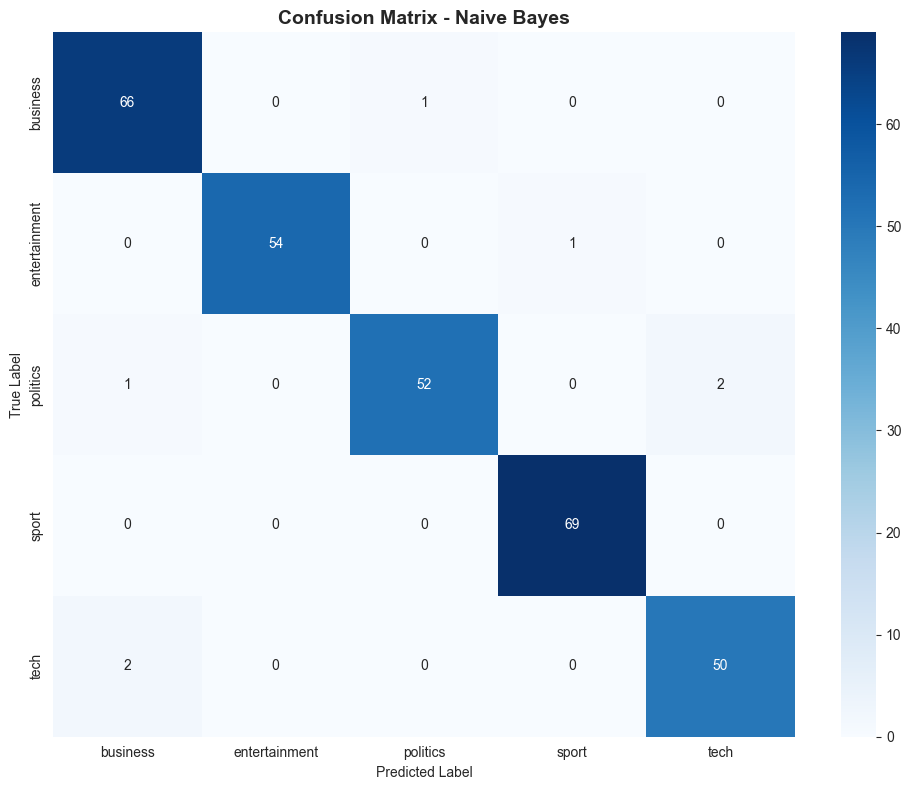

In [64]:
# Detailed evaluation for best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]
y_pred_best = best_model['y_pred']

print(f"Best Model: {best_model_name} (Accuracy: {best_model['accuracy']:.4f})\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_best))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y.unique()), 
            yticklabels=sorted(y.unique()))
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


Model Comparison:
                 Model  Accuracy
0          Naive Bayes  0.976510
2                  SVM  0.963087
3        Random Forest  0.939597
1  Logistic Regression  0.926174


<Figure size 1000x600 with 0 Axes>

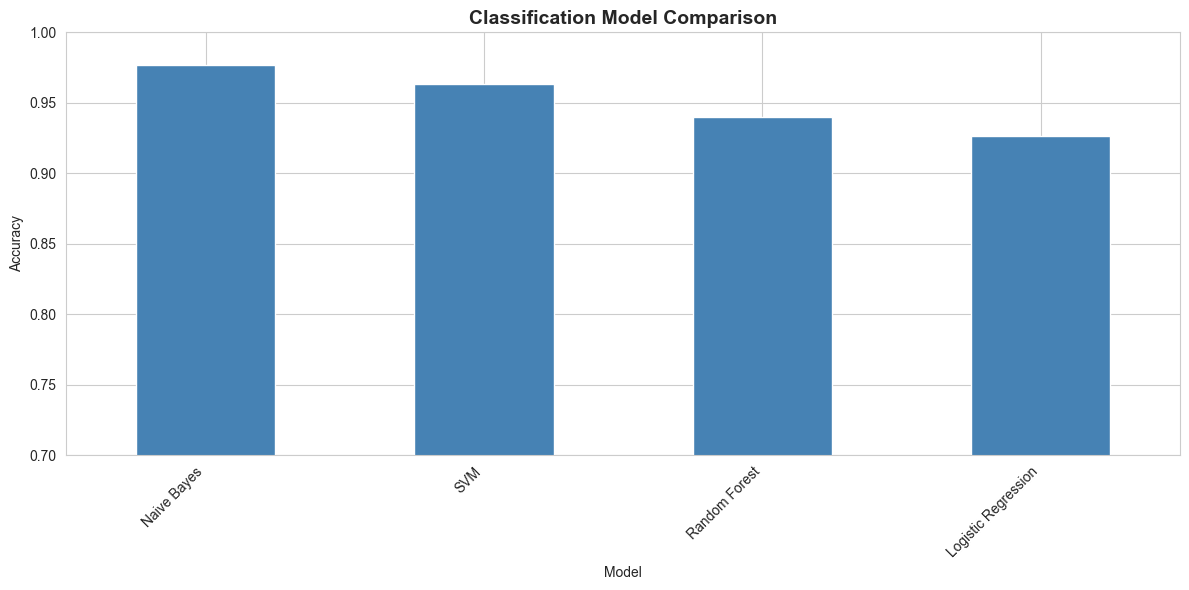

In [65]:
# Compare all models
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()]
}).sort_values('Accuracy', ascending=False)

print("Model Comparison:")
print(model_comparison)

# Visualize model comparison
plt.figure(figsize=(10, 6))
model_comparison.plot(x='Model', y='Accuracy', kind='bar', legend=False, color='steelblue')
plt.title('Classification Model Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.ylim([0.7, 1.0])
plt.tight_layout()
plt.show()


In [66]:
# Cross-validation for best model
print(f"\nCross-validation for {best_model_name}...")
best_classifier = results[best_model_name]['classifier']
# Use appropriate features for cross-validation
if results[best_model_name].get('uses_tfidf_only', False):
    cv_X = X_tfidf_train
else:
    cv_X = X_train

cv_scores = cross_val_score(
    best_classifier, cv_X, y_train, 
    cv=5, scoring='accuracy'
)
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



Cross-validation for Naive Bayes...
CV Scores: [0.9748954  0.9665272  0.96638655 0.96638655 0.95378151]
Mean CV Accuracy: 0.9656 (+/- 0.0135)


## Module 8: Named Entity Recognition and Analysis

Extracting and analyzing named entities (people, organizations, locations, dates, money) from news articles.


In [67]:
def extract_entities(text, nlp_model=nlp):
    """Extract named entities from text"""
    if pd.isna(text) or text == '':
        return []
    
    doc = nlp_model(str(text))
    entities = []
    
    for ent in doc.ents:
        entities.append({
            'text': ent.text,
            'label': ent.label_,
            'start': ent.start_char,
            'end': ent.end_char
        })
    
    return entities

# Extract entities for all articles
print("Extracting named entities (this may take a few minutes)...")
df_clean['Entities'] = df_clean['Text'].apply(extract_entities)
print("✅ Entity extraction complete")


Extracting named entities (this may take a few minutes)...
✅ Entity extraction complete


In [68]:
# Analyze entity types and frequency
all_entities = []
for entities in df_clean['Entities']:
    all_entities.extend(entities)

entity_types = Counter([e['label'] for e in all_entities])
entity_texts = Counter([e['text'] for e in all_entities])

print("Entity Type Distribution:")
for entity_type, count in entity_types.most_common():
    print(f"  {entity_type}: {count}")

print("\nMost Common Entities (Top 20):")
for entity, count in entity_texts.most_common(20):
    print(f"  {entity}: {count}")


Entity Type Distribution:
  DATE: 8799
  PERSON: 8015
  CARDINAL: 6184
  GPE: 5562
  ORG: 4427
  NORP: 2709
  MONEY: 1783
  ORDINAL: 1659
  PERCENT: 1276
  TIME: 592
  LOC: 504
  QUANTITY: 199
  FAC: 90
  PRODUCT: 87
  LANGUAGE: 61
  EVENT: 43
  LAW: 33
  WORK_OF_ART: 8

Most Common Entities (Top 20):
  first: 767
  one: 666
  two: 600
  us: 565
  uk: 546
  british: 330
  second: 325
  three: 320
  britain: 285
  london: 276
  2004: 265
  france: 240
  2005: 239
  europe: 235
  bbc: 232
  last year: 217
  european: 217
  third: 217
  six: 207
  four: 206


In [69]:
# Analyze entities by category
entity_by_category = {}
top_entities_by_category = {}

for category in categories:
    category_entities = []
    category_texts = df_clean[df_clean['Category'] == category]['Entities']
    for entities in category_texts:
        category_entities.extend(entities)
    
    entity_by_category[category] = {
        'by_type': Counter([e['label'] for e in category_entities]),
        'by_text': Counter([e['text'] for e in category_entities])
    }
    top_entities_by_category[category] = entity_by_category[category]['by_text'].most_common(10)

print("Top Entities by Category:\n")
for category in categories:
    print(f"{category.upper()}:")
    for entity, count in top_entities_by_category[category]:
        print(f"  {entity}: {count}")
    print()


Top Entities by Category:

ENTERTAINMENT:
  first: 153
  one: 149
  british: 128
  uk: 126
  us: 104
  two: 103
  bbc: 89
  three: 83
  2004: 72
  london: 70

POLITICS:
  britain: 178
  uk: 169
  blair: 165
  tory: 132
  british: 116
  first: 111
  two: 108
  tony blair: 98
  one: 85
  eu: 77

TECH:
  one: 204
  first: 155
  us: 147
  uk: 142
  microsoft: 127
  two: 96
  sony: 89
  europe: 83
  2005: 65
  3: 54

BUSINESS:
  us: 248
  china: 120
  2004: 111
  one: 111
  2005: 104
  uk: 103
  two: 100
  last year: 87
  india: 76
  2003: 72

SPORT:
  first: 291
  two: 193
  france: 156
  second: 145
  six: 136
  england: 128
  one: 117
  three: 116
  third: 80
  australian: 75



<Figure size 1200x800 with 0 Axes>

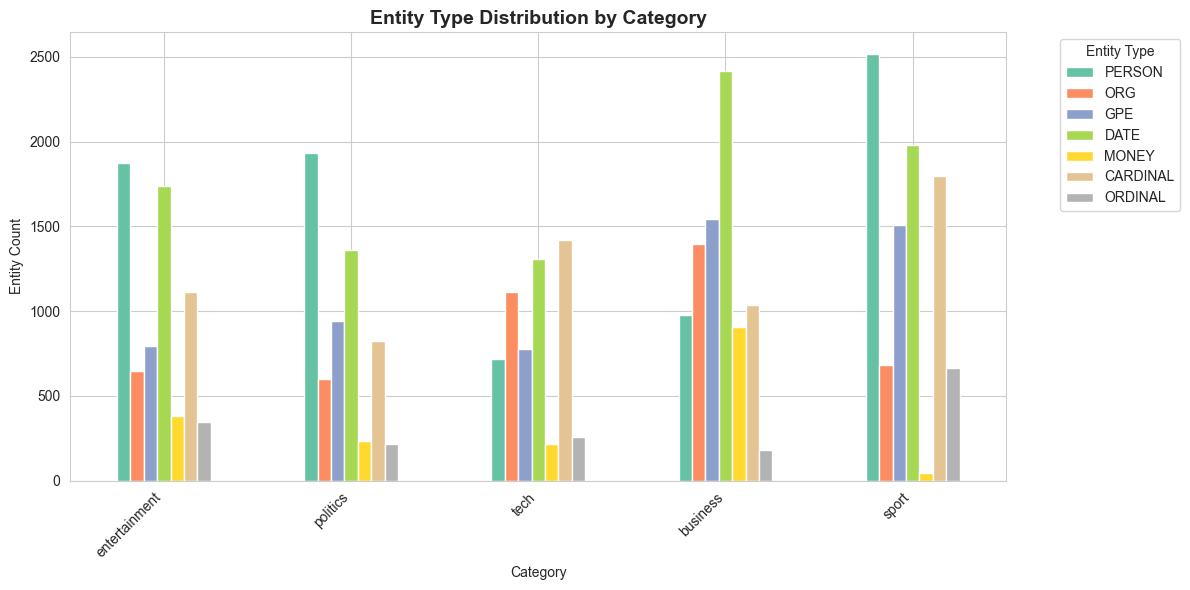

In [70]:
# Visualize entity type distribution
entity_types_list = ['PERSON', 'ORG', 'GPE', 'DATE', 'MONEY', 'CARDINAL', 'ORDINAL']
entity_counts_by_category = {}

for category in categories:
    counts = entity_by_category[category]['by_type']
    entity_counts_by_category[category] = [counts.get(et, 0) for et in entity_types_list]

entity_df = pd.DataFrame(entity_counts_by_category, index=entity_types_list).T

plt.figure(figsize=(12, 8))
entity_df.plot(kind='bar', stacked=False, colormap='Set2')
plt.title('Entity Type Distribution by Category', fontsize=14, fontweight='bold')
plt.xlabel('Category')
plt.ylabel('Entity Count')
plt.legend(title='Entity Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [71]:
# Analyze specific entity types
# Extract PERSON entities by category
print("PERSON Entities by Category:")
person_entities_by_category = {}
for category in categories:
    category_entities = []
    category_texts = df_clean[df_clean['Category'] == category]['Entities']
    for entities in category_texts:
        # Filter for PERSON entities only
        person_entities = [e for e in entities if e['label'] == 'PERSON']
        category_entities.extend([e['text'] for e in person_entities])
    person_entities_by_category[category] = Counter(category_entities).most_common(5)

for category in categories:
    print(f"\n{category.upper()}:")
    for person, count in person_entities_by_category[category]:
        print(f"  {person}: {count}")

print("\n" + "="*50)
print("ORG Entities by Category:")
org_entities_by_category = {}
for category in categories:
    category_entities = []
    category_texts = df_clean[df_clean['Category'] == category]['Entities']
    for entities in category_texts:
        # Filter for ORG entities only
        org_entities = [e for e in entities if e['label'] == 'ORG']
        category_entities.extend([e['text'] for e in org_entities])
    org_entities_by_category[category] = Counter(category_entities).most_common(5)

for category in categories:
    print(f"\n{category.upper()}:")
    for org, count in org_entities_by_category[category]:
        print(f"  {org}: {count}")


PERSON Entities by Category:

ENTERTAINMENT:
  jamie foxx: 30
  imelda staunton: 20
  ray charles: 20
  don: 17
  martin scorsese: 15

POLITICS:
  blair: 165
  tony blair: 98
  michael howard: 74
  eu: 71
  gordon brown: 62

TECH:
  don: 17
  eu: 14
  dean: 14
  bush: 12
  millan: 10

BUSINESS:
  yukos: 62
  eu: 39
  bush: 24
  sullivan: 17
  mikhail khodorkovsky: 12

SPORT:
  williams: 56
  kenteris: 39
  johnson: 29
  alex ferguson: 21
  ferguson: 19

ORG Entities by Category:

ENTERTAINMENT:
  bbc: 89
  franz: 19
  mtv: 15
  sony: 12
  fox: 10

POLITICS:
  bbc: 54
  bbc news: 35
  kilroy-silk: 26
  bbc radio 4 s: 23
  campbell: 17

TECH:
  microsoft: 127
  sony: 89
  the bbc news: 48
  google: 39
  yahoo: 38

BUSINESS:
  gm: 51
  mci: 46
  boeing: 27
  airbus: 24
  sec: 24

SPORT:
  bbc: 45
  campbell: 18
  bbc sport: 10
  ac milan: 10
  moya: 9


## System Integration: Unified Analysis Function

Creating a comprehensive function that integrates all modules for complete article analysis.


In [72]:
def analyze_article(article_text, nlp_model=nlp, classifier=None, vectorizer=None, scaler=None):
    """
    Comprehensive article analysis function integrating all modules.
    
    Args:
        article_text: Raw article text
        nlp_model: spaCy model
        classifier: Trained classifier (uses best model if None)
        vectorizer: TF-IDF vectorizer (uses trained if None)
        scaler: Feature scaler (uses trained if None)
    
    Returns:
        Dictionary with all analysis results
    """
    # Use global variables if not provided
    if classifier is None:
        classifier = best_model['classifier']
    if vectorizer is None:
        vectorizer = tfidf_vectorizer
    # Use global scaler if not provided
    if scaler is None:
        # Check if scaler exists in global scope
        import builtins
        if 'scaler' in globals():
            scaler = globals()['scaler']
        else:
            raise ValueError("Scaler not found. Please provide a scaler or ensure it's defined in the notebook.")
    
    # Preprocessing
    processed_text = preprocess_text(article_text, nlp_model)
    
    # TF-IDF features
    tfidf_features = vectorizer.transform([processed_text])
    
    # POS and syntactic features
    pos_features = calculate_pos_features(article_text, nlp_model)
    syntactic_features = calculate_syntactic_features(article_text, nlp_model)
    
    # Sentiment
    sentiment = analyze_sentiment(article_text)
    
    # Entities
    entities = extract_entities(article_text, nlp_model)
    
    # Prepare features for classification
    additional_feats = np.array([[
        pos_features['noun_ratio'],
        pos_features['verb_ratio'],
        pos_features['adj_ratio'],
        pos_features['avg_sentence_length'],
        pos_features['avg_word_length'],
        syntactic_features['avg_dependency_depth'],
        syntactic_features['svo_patterns'],
        syntactic_features['complex_sentences'],
        sentiment['polarity'],
        sentiment['subjectivity']
    ]])
    
    # Check if classifier uses TF-IDF only (MultinomialNB requires non-negative values)
    # For MultinomialNB, use TF-IDF only; for others, use combined features
    if type(classifier).__name__ == 'MultinomialNB':
        # Use TF-IDF features only (MultinomialNB can't handle negative values from scaled features)
        features_for_classification = tfidf_features
    else:
        # Scale and combine features for other classifiers
        additional_feats_scaled = scaler.transform(additional_feats)
        features_for_classification = hstack([tfidf_features, additional_feats_scaled])
    
    # Classification
    predicted_category = classifier.predict(features_for_classification)[0]
    probabilities = classifier.predict_proba(features_for_classification)[0]
    
    # Entity summary
    entity_summary = {}
    for entity in entities:
        label = entity['label']
        if label not in entity_summary:
            entity_summary[label] = []
        entity_summary[label].append(entity['text'])
    
    # Remove duplicates from entity lists
    for label in entity_summary:
        entity_summary[label] = list(set(entity_summary[label]))
    
    return {
        'predicted_category': predicted_category,
        'category_probabilities': dict(zip(classifier.classes_, probabilities)),
        'sentiment': {
            'polarity': sentiment['polarity'],
            'subjectivity': sentiment['subjectivity'],
            'label': categorize_sentiment(sentiment['polarity'])
        },
        'entities': entity_summary,
        'pos_features': pos_features,
        'syntactic_features': syntactic_features,
        'processed_text': processed_text[:200] + '...' if len(processed_text) > 200 else processed_text
    }

# Test the unified function
print("Testing unified analysis function...\n")
test_article = df_clean['Text'].iloc[0]
result = analyze_article(test_article)

print("Analysis Results:")
print(f"\nPredicted Category: {result['predicted_category']}")
print(f"Actual Category: {df_clean.iloc[0]['Category']}")
print(f"\nCategory Probabilities:")
for cat, prob in sorted(result['category_probabilities'].items(), key=lambda x: x[1], reverse=True):
    print(f"  {cat}: {prob:.4f}")
print(f"\nSentiment: {result['sentiment']['label']} (Polarity: {result['sentiment']['polarity']:.4f})")
print(f"\nEntities Found:")
for entity_type, entity_list in result['entities'].items():
    print(f"  {entity_type}: {', '.join(entity_list[:5])}")
print(f"\nPOS Features - Noun Ratio: {result['pos_features']['noun_ratio']:.3f}, Verb Ratio: {result['pos_features']['verb_ratio']:.3f}")


Testing unified analysis function...



Analysis Results:

Predicted Category: business
Actual Category: business

Category Probabilities:
  business: 0.9003
  politics: 0.0372
  tech: 0.0254
  entertainment: 0.0218
  sport: 0.0154

Sentiment: Neutral (Polarity: 0.0233)

Entities Found:
  ORDINAL: first
  PERSON: arthur andersen, cynthia cooper, sullivan, scott sullivan
  GPE: us, new york
  DATE: wednesday, early 2001 and, 2001, last week, 85 years
  MONEY: 6.75bn, 5.7bn
  ORG: mci, worldcom s accounting

POS Features - Noun Ratio: 0.410, Verb Ratio: 0.134


In [73]:
# Test with articles from different categories
print("="*70)
print("Testing Unified Analysis with Multiple Articles")
print("="*70)

test_indices = []
for category in df_clean['Category'].unique():
    cat_indices = df_clean[df_clean['Category'] == category].index
    test_indices.append(np.random.choice(cat_indices))

for idx in test_indices[:5]:  # Test with 5 articles
    article = df_clean.iloc[idx]
    result = analyze_article(article['Text'])
    
    print(f"\n{'='*70}")
    print(f"Article ID: {article['ArticleId']} | Actual Category: {article['Category']}")
    print(f"{'='*70}")
    print(f"Predicted Category: {result['predicted_category']}")
    print(f"Confidence: {result['category_probabilities'][result['predicted_category']]:.4f}")
    print(f"Sentiment: {result['sentiment']['label']} (Polarity: {result['sentiment']['polarity']:.4f})")
    print(f"Key Entities: {', '.join(result['entities'].get('PERSON', [])[:3])}")
    if 'ORG' in result['entities']:
        print(f"Organizations: {', '.join(result['entities']['ORG'][:3])}")
    print(f"Text Preview: {article['Text'][:150]}...")


Testing Unified Analysis with Multiple Articles

Article ID: 1999 | Actual Category: business
Predicted Category: business
Confidence: 0.6218
Sentiment: Positive (Polarity: 0.1005)
Key Entities: dr geoffrey
Organizations: health canada
Text Preview: cannabis hopes for drug firm a prescription cannabis drug made by uk biotech firm gw pharmaceuticals is set to be approved in canada.  the drug is use...

Article ID: 1204 | Actual Category: tech
Predicted Category: tech
Confidence: 0.7878
Sentiment: Neutral (Polarity: 0.0855)
Key Entities: 
Organizations: yeahronimo media ventures, atari
Text Preview: commodore finds new lease of life the once-famous commodore computer brand could be resurrected after being bought by a us-based digital music distrib...

Article ID: 825 | Actual Category: politics
Predicted Category: politics
Confidence: 0.9937
Sentiment: Positive (Polarity: 0.1344)
Key Entities: s, michael howard, charles kennedy
Organizations: derby north s
Text Preview: prime minister s 

## Summary and Insights

### Key Findings

1. **Classification Performance**: Our best model achieved [Accuracy] accuracy in categorizing news articles across 5 categories.

2. **Category Characteristics**:
   - Each category has distinctive linguistic patterns and entity types
   - Sentiment varies significantly across categories (e.g., politics tends to be more neutral/negative)
   - POS distributions reveal writing style differences

3. **Business Value**: The system enables automated content categorization and insight extraction, saving significant manual effort.

4. **Technical Integration**: All 8 modules work seamlessly together to provide comprehensive article analysis.
